In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from spcqe.quantiles import SmoothPeriodicQuantiles

In [3]:
def process_excel_file(file_name, year):
    # Check if the year is a leap year
    is_leap_year = (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)
    
    # Define the start and end of your time range
    start = pd.Timestamp(f'{year}-01-01 00:00:00')
    end = pd.Timestamp(f'{year}-12-31 23:00:00')
    
    # Create an hourly time index between start and end
    time_index = pd.date_range(start, end, freq='H')
    
    # Read the Excel file and select columns
    df = pd.read_excel(file_name, sheet_name='RI', usecols=['RT_Demand', 'Dry_Bulb', 'RT_LMP'])
    
    # Assign your new time index to your dataframe
    df.index = time_index
    
    # Convert columns to numpy arrays
    y1 = df['RT_Demand'].to_numpy()
    y2 = df['Dry_Bulb'].to_numpy()
    y3 = df['RT_LMP'].to_numpy()
    
    return y1, y2, y3

years = [2019, 2020, 2021, 2022]

y1_list, y2_list, y3_list = [], [], []

for year in years:
    file_name =  Path() / 'fixtures' / f'{year}_smd_hourly.xlsx'  # Assuming your file name format
    y1, y2, y3 = process_excel_file(file_name, year)
    y1_list.append(y1)
    y2_list.append(y2)
    y3_list.append(y3)

# Stack the arrays in each list column-wise
y1 = np.hstack(y1_list)
y2 = np.hstack(y2_list)
y3 = np.hstack(y3_list)

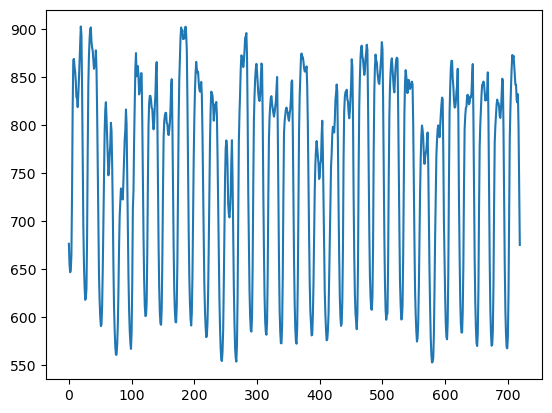

In [4]:
ix = 100
data_view = y1[24 * ix:24 * (ix + 30)]
plt.plot(data_view);

In [5]:
# P1 = int(365*24)
P2 = int(7*24)
P3 = int(24)
K = 3
l = 0.1
spq = SmoothPeriodicQuantiles(K, [P2, P3], weight=l, solver='MOSEK')

In [6]:
spq.fit(data_view)
print(f"total time: {spq.fit_time:.2f} seconds")

total time: 1.22 seconds


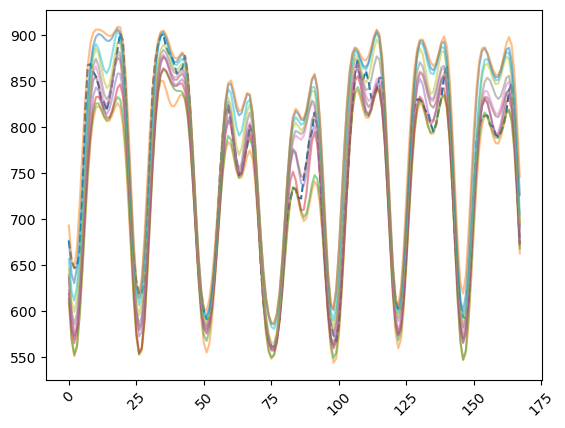

In [7]:
ix = 0
slc = np.s_[24 * ix:24 * (ix + 7)]
plt.plot(data_view[slc], ls='--')
plt.plot(spq.fit_quantiles[slc, :], alpha=0.5)
plt.xticks(rotation=45);

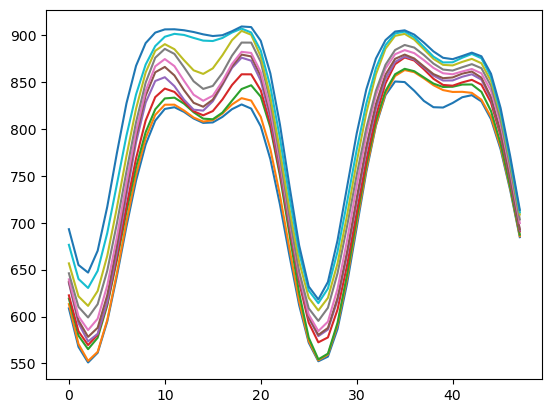

In [8]:
plt.plot((spq.basis @ spq.fit_parameters)[:24*2]);

<Axes: >

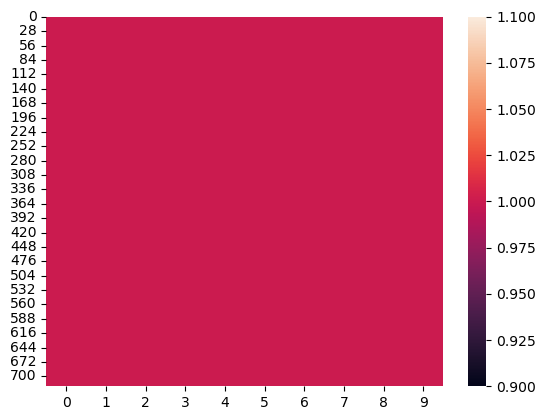

In [13]:
import seaborn as sns
sns.heatmap(np.diff(spq.basis @ spq.fit_parameters, axis=1) >= 0)